# COMP 9517 Project - Individual Component 
### vehicle detection
#### z5151812 Haonan Zhang
- generate ROI
- extract features
- training classifier model 
- use slide window search vehicles in an image 
- draw bounding boxes around vehicles

Import relevant packages

In [1]:
import cv2
import os
import copy
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from scipy.ndimage import label, generate_binary_structure

In [2]:
# refer class from demo code: tusimple-benchmark/evaluate/velocity.py /
class VeloEval(object):
    @staticmethod
    def load_json_file(file_list):
        data_list = []
        for file_name in file_list:
            with open(file_name) as f:
                raw_data = json.load(f)
            data_list.append(raw_data)
        return data_list

    @staticmethod
    def transform_annotation(raw_data_list):
        anno_list = []
        for raw_data in raw_data_list:
            data = []
            for instance in raw_data:
                instance["bbox"] = np.array([[instance["bbox"]["top"],
                                              instance["bbox"]["left"],
                                              instance["bbox"]["bottom"],
                                              instance["bbox"]["right"]]])
                data.append(instance)
            anno_list.append(data)
        return anno_list

    @staticmethod
    def load_annotation(file_list):
        raw_data_list = VeloEval.load_json_file(file_list)
        anno_list = VeloEval.transform_annotation(raw_data_list)
        print ("Finished loading {0:d} annotations.".format(len(anno_list)))
        return anno_list

- load training dataset

In [3]:
## read file
# file path
dataset_path = './benchmark_velocity_train/clips/'
# create a file list
folder_path = os.listdir(dataset_path)
# transfer file list name to int
folder_int = [int(i) for i in folder_path]
# sort int name list
folder_sort = sorted(folder_int)

In [4]:
## read image
# list of image
L_img = []
# annotation JSON file
annotations = [os.path.join(dataset_path, str(x) + '/annotation.json') for x in folder_sort]
# 1074 img files
img = [os.path.join(dataset_path, str(x) + '/imgs') for x in folder_sort]

for i in img:
    # traverse file sys
    for (root,dirs,files) in os.walk(i,'jpg'):
        files.sort()
#         print(files)
        image = cv2.imread(os.path.join(i,files[-1]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        L_img.append(image)

In [5]:
len(L_img)

1074

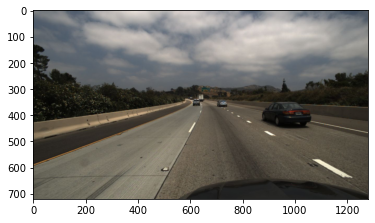

In [6]:
plt.imshow(L_img[-1])

In [7]:
# load annotation
gt = VeloEval.load_annotation(annotations)

Finished loading 1074 annotations.


In [8]:
gt[0][0]['bbox'][0]

array([340.34182739, 784.66387939, 393.32751465, 868.15374756])

- generate ROI

In [9]:
## extract vehicles images
# list to store target vehicles image
L_vehicle = []
for n in range(0, len(gt)):
    # the nth annotation dict
    gt_n = gt[n][0]
    # read array info
    top = int(gt_n['bbox'][0][0])
    left = int(gt_n['bbox'][0][1])
    bottom = int(gt_n['bbox'][0][2])
    right = int(gt_n['bbox'][0][3])

    curr_img = L_img[n]
    # extract target vehicles
    target_vehi = curr_img[top:bottom, left:right]
    L_vehicle.append(target_vehi)
len(L_vehicle)

1074

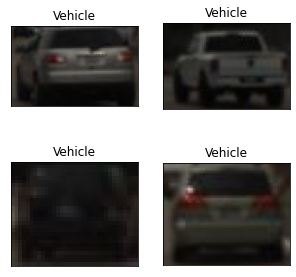

In [10]:
# display the first 4 images of vehicle ROI
plt.figure(figsize=(5,5))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Vehicle')
    plt.imshow(L_vehicle[i], cmap=plt.cm.binary)
plt.show()

In [11]:
## cover target vehicle
# list to store image that cover vehicle with black
L_cover = []
for n in range(0, len(L_img)):
    curr_img = L_img[n]
    # copy original image to cover
    cover = np.copy(curr_img)
    # the nth annotation dict
    gt_n = gt[n][0]
    # read array info
    top = int(gt_n['bbox'][0][0])
    left = int(gt_n['bbox'][0][1])
    bottom = int(gt_n['bbox'][0][2])
    right = int(gt_n['bbox'][0][3])

    # cover vehicle
    (h, w) = cover.shape[:2]
    for x in range(h):
        for y in range(w):
            if top <= x <= bottom:
                if left <= y <= right:
                    cover[x, y] = 0
    L_cover.append(cover)

In [12]:
## crop image, remove unuseful part
# list to store cropped image
L_crop = []
for i in range(0, len(L_cover)):
    curr_img =  L_cover[i]
    crop_img = curr_img[250:634, :]
    L_crop.append(crop_img)
L_crop[0].shape

(384, 1280, 3)

In [13]:
## extract non-vehicles as negative
# list to store non-vehicles image
L_non = []
for i in range(0, len(L_crop)):
    curr_img = L_crop[i]
    (h, w) = curr_img.shape[:2]

    # define bounding
    top = 0
    bottom = 64
    while top <=320:
        left = 0
        right = 64
        while left <= 1216:
            non_veh = curr_img[top:bottom, left:right]
            L_non.append(non_veh)
            left += 64
            right += 64
        top += 64
        bottom += 64

L_non = random.sample(L_non, 1074)
len(L_non)

1074

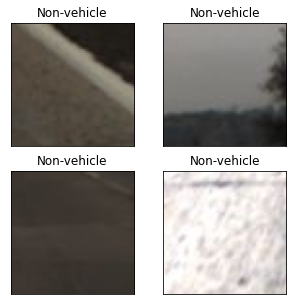

In [14]:
# randomly display 4 images of non-vehicle ROI
a = random.sample(L_non, 4)
# display the first 25 images of non-vehicle image list
plt.figure(figsize=(5,5))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Non-vehicle')
    plt.imshow(a[i], cmap=plt.cm.binary)
plt.show()

In [15]:
# resize vehicle image
resize_veh = []
for img in L_vehicle:
    resize_img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
    resize_veh.append(resize_img)
resize_veh[0].shape

(64, 64, 3)

- extract features

In [16]:
## use HOG extract features
def get_features(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)
    return fd

In [17]:
# vehicle image features
vehi_features = []
for img in resize_veh:
    features = get_features(img)
    vehi_features.append(features)
vehi_features[0]

array([0.35355339, 0.35355339, 0.35355339, 0.35355339, 0.35355339,
       0.35355339, 0.35355339, 0.35355339, 0.44752148, 0.44752148,
       0.38504431, 0.44752148, 0.44752148, 0.11391098, 0.16420134,
       0.10344649, 0.24090998, 0.06335481, 0.19687793, 0.6506627 ,
       0.6506627 , 0.16050956, 0.16060323, 0.03011672, 0.38188518,
       0.16541294, 0.31244328, 0.38188518, 0.38188518, 0.38188518,
       0.38188518, 0.38188518, 0.39470658, 0.39470658, 0.32317198,
       0.28823444, 0.39470658, 0.32459245, 0.28973673, 0.39470658,
       0.33011063, 0.32272387, 0.26671055, 0.38350485, 0.38350485,
       0.38350485, 0.38350485, 0.35698441, 0.15496693, 0.23793004,
       0.44712563, 0.44712563, 0.44712563, 0.32617424, 0.44712563,
       0.11532386, 0.37320668, 0.37320668, 0.37320668, 0.37320668,
       0.37320668, 0.15816897, 0.37320668, 0.37320668, 0.53621714,
       0.27282044, 0.08098315, 0.00943421, 0.17988144, 0.30764871,
       0.46568125, 0.53621714, 0.19541897, 0.18100687, 0.17764

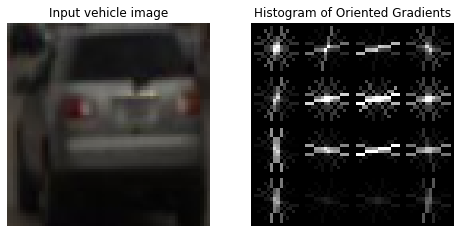

In [18]:
# display hog image of vehicle

image = resize_veh[0]

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input vehicle image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


In [19]:
# non-vehicle image features
non_features = []
for img in L_non:
    features = get_features(img)
    non_features.append(features)
non_features[0]

array([0.16703352, 0.01949133, 0.26248644, 0.10782072, 0.80566416,
       0.44074689, 0.21873018, 0.        , 0.43690169, 0.0338927 ,
       0.25172745, 0.23025532, 0.63084873, 0.4575515 , 0.28629189,
       0.04793151, 0.4570793 , 0.34157566, 0.4570793 , 0.4570793 ,
       0.4570793 , 0.07790713, 0.09277992, 0.18155576, 0.35355339,
       0.35355339, 0.35355339, 0.35355339, 0.35355339, 0.35355339,
       0.35355339, 0.35355339, 0.24056518, 0.02831158, 0.3980508 ,
       0.08007725, 0.71832948, 0.31142746, 0.4043337 , 0.        ,
       0.23941787, 0.0793118 , 0.45394146, 0.        , 0.53366402,
       0.33385026, 0.53366402, 0.22198039, 0.37315449, 0.34440507,
       0.33924766, 0.26471647, 0.37315449, 0.37315449, 0.37315449,
       0.37315449, 0.35355339, 0.35355339, 0.35355339, 0.35355339,
       0.35355339, 0.35355339, 0.35355339, 0.35355339, 0.3825809 ,
       0.36544473, 0.41861183, 0.41861183, 0.41861183, 0.18742501,
       0.39203443, 0.07453378, 0.36618751, 0.36618751, 0.36618

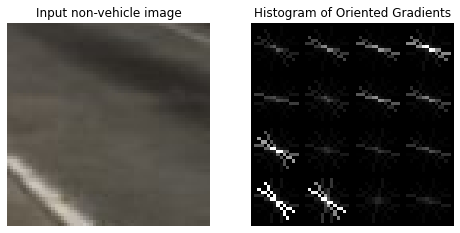

In [20]:
# display hog image of non-vehicle

image = L_non[12]

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input non-vehicle image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

- training classifier model

In [21]:
## split training data
image = np.vstack((vehi_features, non_features)).astype(np.float64)
# vehicle:1，non-vehicle:0
label = np.hstack((np.ones(len(vehi_features)), np.zeros(len(non_features))))
train_img,test_img,train_label,test_label = train_test_split(image,label,test_size = 0.2)

In [22]:
## train model
# initialize models
svm_clf = LinearSVC()
# fit models to training data
svm_clf.fit(train_img,train_label)
# predict
pred_label = svm_clf.predict(test_img)
print(classification_report(test_label, pred_label))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       220
         1.0       0.98      0.99      0.98       210

    accuracy                           0.98       430
   macro avg       0.98      0.98      0.98       430
weighted avg       0.98      0.98      0.98       430



- search vehicles

In [23]:
## slide window
def slide_window(img, boundary_y, window_size, stride):
    # define boundary；
    boundary_x = [0, img.shape[1]]
    xspan = boundary_x[1] - boundary_x[0]
    yspan = boundary_y[1] - boundary_y[0]
    step = window_size * (1 - stride)
    pixel_step = int(step)
    buf = window_size * (stride)
    buff = int(buf)
    w_x = (xspan - buff) / pixel_step
    win_x = int(w_x)
    w_y = (yspan - buff) / pixel_step
    win_y = int(w_y)
    L_win = []
    for y in range(win_y):
        for x in range(win_x):
            # Calculate window position
            left = x * pixel_step + boundary_x[0]
            Top = y * pixel_step + boundary_y[0]
            L_win.append(((left, Top), (left + window_size, Top + window_size)))
    return L_win

In [24]:
def variable_size_window(img, clf):
    y_start_stops = [[300, 500], [300, 500], [400, 600], [400, 650]]
    win_size = [64, 128, 256]
    vehicle_windows = []
    for i in range(len(y_start_stops)):
        if i == 0:
            window_size = win_size[0]
        if i == 1:
            window_size = win_size[1]
        if i == 2:
            window_size = win_size[1]
        if i == 3:
            window_size = win_size[2]

        windows = slide_window(img, boundary_y=[y_start_stops[i][0], y_start_stops[i][1]],
                               window_size= window_size, stride=0.87)

        vehicle_win = []
        for w in windows:
            window_img = cv2.resize(img[w[0][1]:w[1][1], w[0][0]:w[1][0]], (64, 64))

            features = get_features(window_img)
            features = features.reshape(1, -1)

            pred = clf.predict(features)
            if pred == 1:
                vehicle_win.append(w)
        windows = vehicle_win

        vehicle_windows.extend(windows)
    return np.array(vehicle_windows)

In [25]:
## load test dataset
dataset_path = './benchmark_velocity_test/clips/'
folder_path = os.listdir(dataset_path)
folder_int = [int(i) for i in folder_path]
folder_sort = sorted(folder_int)

In [26]:
## read image
test_data = []
# annotation JSON file
annotations = [os.path.join(dataset_path, str(x) + '/annotation.json') for x in folder_sort]
# 1074 img files
img = [os.path.join(dataset_path, str(x) + '/imgs') for x in folder_sort]

for i in img:
    # traverse file sys
    for (root,dirs,files) in os.walk(i,'jpg'):
        files.sort()
#         print(files)
        image = cv2.imread(os.path.join(i,files[-1]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        test_data.append(image)

In [27]:
from scipy.ndimage import label, generate_binary_structure
def generate_final_bbox(image, boxes, thr):
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    for b in boxes:
        heat[b[0][1]:b[1][1], b[0][0]:b[1][0]] += 1

    heat[heat <= thr] = 0
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    img = np.copy(image)
    for cnt_vehicle in range(1, labels[1] + 1):
        nonzero = (labels[0] == cnt_vehicle).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 6)

    return heatmap, img

(<matplotlib.image.AxesImage at 0x2ba06f420c8>,
 Text(0.5, 1.0, 'output image'),
 ([], []),
 ([], []))

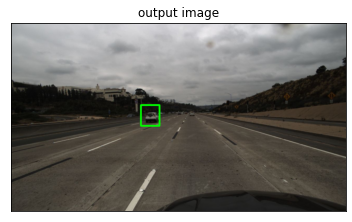

In [28]:
img = test_data[0]
window_box = variable_size_window(img, svm_clf)
heatmap,draw_image = generate_final_bbox(img, window_box, thr=2)
plt.imshow(draw_image),plt.title('output image'), plt.xticks([]), plt.yticks([])